In [1]:
import sys
sys.path.append('../')

import os
import numpy as np
import pandas as pd
from datetime import datetime
from typing import List, Tuple, Optional, Union

from src.config import Config
from src.analysis.scraper import Scraper
from src.analysis.preprocessing import *

import warnings
warnings.filterwarnings("ignore")

## Stock

In [5]:
scraper = Scraper()

stock_df = scraper.get_stock_data(ticker="AAPL")

Successfully retrieved stock data for AAPL - 6076


In [2]:
# features, target = fire.Fire(transform_ts_data_into_features_and_target)
features, target = transform_ts_data_into_features_and_target()

preprocessing_pipeline = get_preprocessing_pipeline()

preprocessing_pipeline.fit(features)
X = preprocessing_pipeline.transform(features)

2023-12-25 16:23:08,734 - tutorial - INFO - time column already in datetime format
2023-12-25 16:23:08,738 - tutorial - INFO - pre-compute cutoff indices to split dataframe rows
2023-12-25 16:23:08,739 - tutorial - INFO - pre-compute cutoff indices to split dataframe rows at input sequence length and step size of 24


2023-12-25 16:23:09,249 - tutorial - INFO - Adding percentage return of price at hour 2 to the input DataFrame
2023-12-25 16:23:09,251 - tutorial - INFO - Adding percentage return of price at hour 12 to the input DataFrame
2023-12-25 16:23:09,253 - tutorial - INFO - Adding percentage return of price at hour 24 to the input DataFrame
2023-12-25 16:23:09,254 - tutorial - INFO - Adding RSI to the input DataFrame
2023-12-25 16:23:15,441 - tutorial - INFO - Adding percentage return of price at hour 2 to the input DataFrame
2023-12-25 16:23:15,443 - tutorial - INFO - Adding percentage return of price at hour 12 to the input DataFrame
2023-12-25 16:23:15,445 - tutorial - INFO - Adding percentage return of price at hour 24 to the input DataFrame
2023-12-25 16:23:15,446 - tutorial - INFO - Adding RSI to the input DataFrame


## Crypto

In [2]:
scraper = Scraper()

scraper.download_ohlc_data_from_coinbase()

File c:\Users\kewjs\Documents\02-Self_Learning\01-Data_Science\15-Time_Series_Forecasting\notebooks\..\data\raw_data\crypto\2020-01-01.parquet already exists, skipping
File c:\Users\kewjs\Documents\02-Self_Learning\01-Data_Science\15-Time_Series_Forecasting\notebooks\..\data\raw_data\crypto\2020-01-02.parquet already exists, skipping
File c:\Users\kewjs\Documents\02-Self_Learning\01-Data_Science\15-Time_Series_Forecasting\notebooks\..\data\raw_data\crypto\2020-01-03.parquet already exists, skipping
File c:\Users\kewjs\Documents\02-Self_Learning\01-Data_Science\15-Time_Series_Forecasting\notebooks\..\data\raw_data\crypto\2020-01-04.parquet already exists, skipping
File c:\Users\kewjs\Documents\02-Self_Learning\01-Data_Science\15-Time_Series_Forecasting\notebooks\..\data\raw_data\crypto\2020-01-05.parquet already exists, skipping
File c:\Users\kewjs\Documents\02-Self_Learning\01-Data_Science\15-Time_Series_Forecasting\notebooks\..\data\raw_data\crypto\2020-01-06.parquet already exists, s

'c:\\Users\\kewjs\\Documents\\02-Self_Learning\\01-Data_Science\\15-Time_Series_Forecasting\\notebooks\\..\\data\\preprocess_data\\crypto\\ohlc_data.parquet'

### Understand Scraped Crypto

In [3]:
from comet_ml import Experiment
from comet_ml.integration.pytorch import log_model

experiment = Experiment(
  api_key="sjuuFEUblpw7zX984v7pquGw2",
  project_name="ts-forecasting",
  workspace="kewjs"
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in 'c:\\Users\\kewjs\\Documents\\02-Self_Learning\\01-Data_Science\\15-Time_Series_Forecasting\\notebooks' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/kewjs/ts-forecasting/5933b894016043adb14fc8772258a258



In [4]:
ts_data = pd.read_parquet(os.path.join(Config.FILES["PREPROCESS_DATA"], "crypto", "ohlc_data.parquet"))
ts_data = ts_data[["time", "close"]]
ts_data["time"] = ts_data["time"].apply(lambda x: datetime.fromtimestamp(x))
ts_data.sort_values(by=["time"], inplace=True)

In [6]:
def get_cut_off_indices_features_and_target(
    data: pd.DataFrame,
    input_seq_len: int,
    step_size: int
    ) -> List[Tuple[int, int, int]]:
    stop_position = len(data) - 1
    
    subseq_first_idx = 0
    subseq_mid_idx = input_seq_len
    subseq_last_idx = input_seq_len + 1
    indices = []
    
    while subseq_last_idx <= stop_position:
        indices.append((subseq_first_idx, subseq_mid_idx, subseq_last_idx))
        subseq_first_idx += step_size
        subseq_mid_idx += step_size
        subseq_last_idx += step_size
        
    return indices

In [20]:
input_seq_len = 24
step_size = 1

features = pd.DataFrame()
targets = pd.DataFrame()

indices = get_cut_off_indices_features_and_target(ts_data, input_seq_len, step_size)

n_examples = len(indices)
x = np.ndarray(shape=(n_examples, input_seq_len), dtype=np.float32)
y = np.ndarray(shape=(n_examples), dtype=np.float32)
times = []
for i, idx in enumerate(indices):
    x[i, :] = ts_data.iloc[idx[0]:idx[1]]["close"].values
    y[i] = ts_data.iloc[idx[1]:idx[2]]["close"].values
    times.append(ts_data.iloc[idx[1]]["time"])
    
features = pd.DataFrame(x,
                        columns=[f"price_{i+1}_hour_ago" for i in reversed(range(input_seq_len))]
                        )

targets = pd.DataFrame(y, columns=[f"target_price_next_hour"])

## Radiation

In [ ]:
from src.analysis import Analysis
from src.analysis.scraper import Scraper

In [ ]:
analysis = Analysis()
self = analysis

In [ ]:
scraper.noaa_scraper()

In [ ]:
self.get_data()

  read in merged solar radiation file...
  updating dataframe datetime index to UTC localized format and drop individual time components...
    > merge_2017
    > merge_2018
    > merge_2019
    > merge_2020
    > merge_2021
    > merge_2022
    > merge_2023
  create train & test dataset at ratio 0.2...
    > train data from ['merge_2017', 'merge_2018', 'merge_2019', 'merge_2020', 'merge_2021']
    > validation data from ['merge_2022']
    > test data from ['merge_2023']
  create train, validation and test data at 'hourly' interval...
  missing values interpolations...
  get the univariate target feature 'netsolar'...
  export 'merge' train, validation and test data at interval hourly...


## Stationary Checking

In [ ]:
self.lineplot_plotly(df=self.merge_train_d, groupby_col="city", col="netsolar")

In [ ]:
self.roll_mean_plot(train_dict=self.merge_train_d, roll_mean_d=self.roll_mean_d)

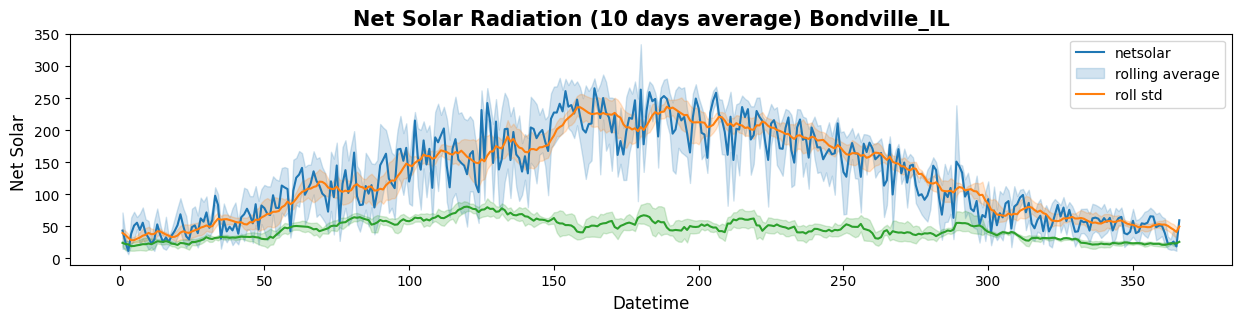

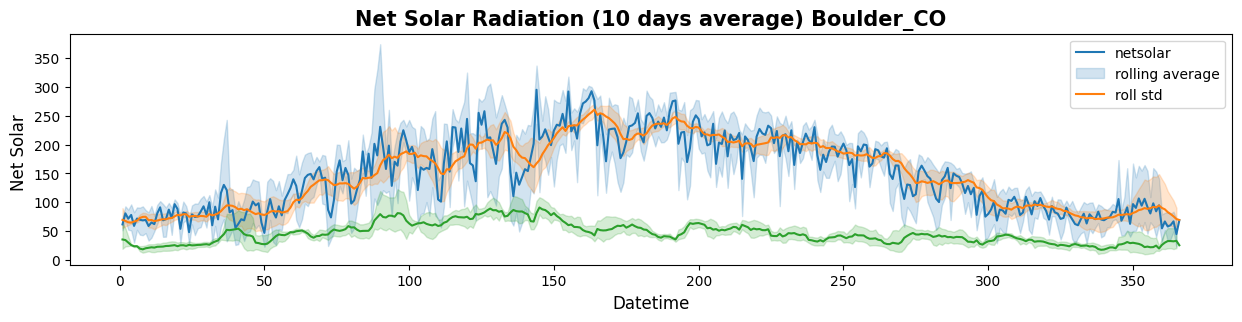

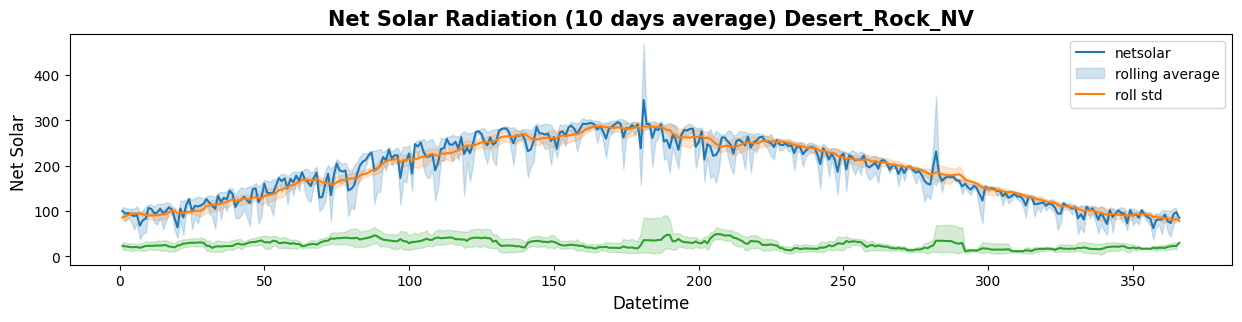

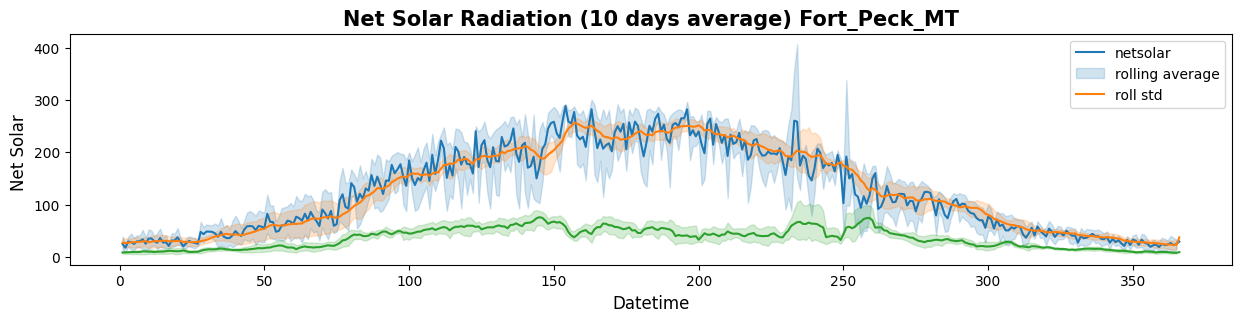

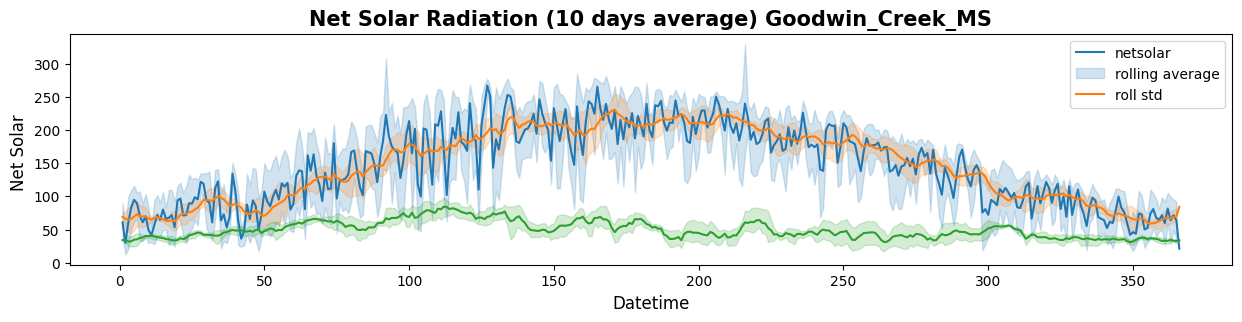

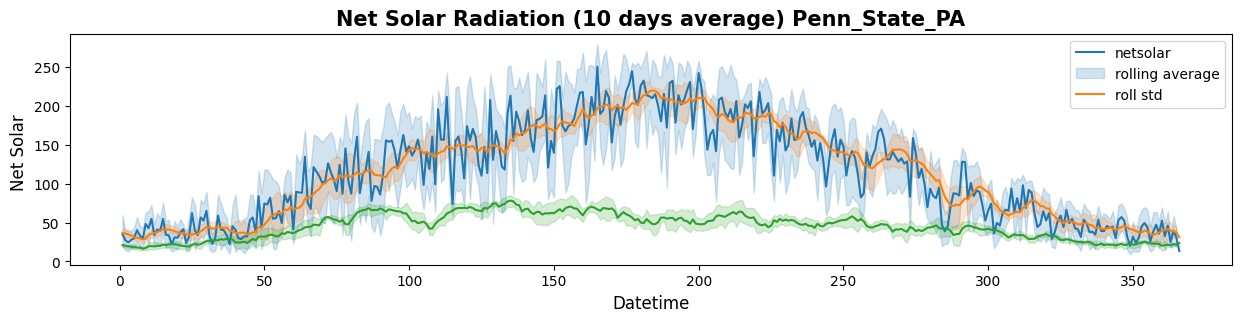

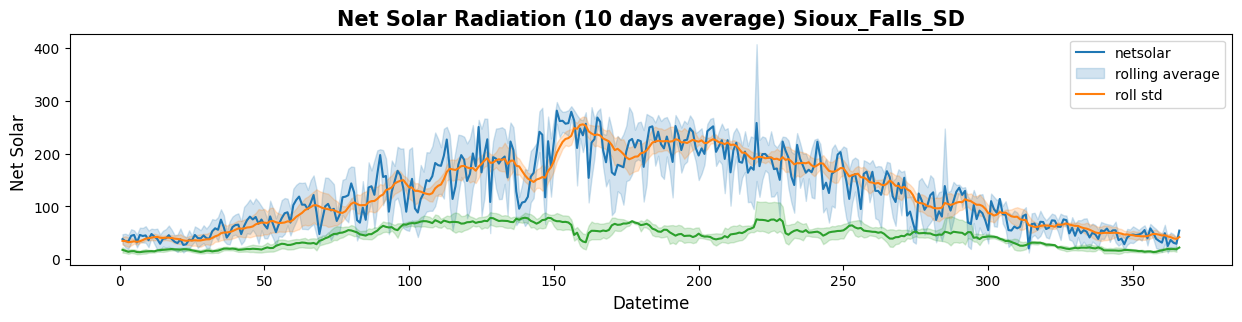

In [ ]:
column = "netsolar"

for location in self.merge_train_d["city"].unique():    
    plt.figure(figsize=(15,3))
    sns.lineplot(data=self.merge_train_d[self.merge_train_d["city"]==location], x="jday", y=column)
    sns.lineplot(data=self.roll_mean_d[location], x="jday", y=column)
    sns.lineplot(data=self.roll_std_d[location], x="jday", y=column)

    plt.xlabel("Datetime", fontsize=12)
    plt.ylabel("Net Solar ", fontsize=12)
    plt.legend([column, "rolling average", "roll std"], fontsize=10)
    plt.title(f"Net Solar Radiation (10 days average) {location}", fontsize=15, fontweight="bold")
    plt.show()

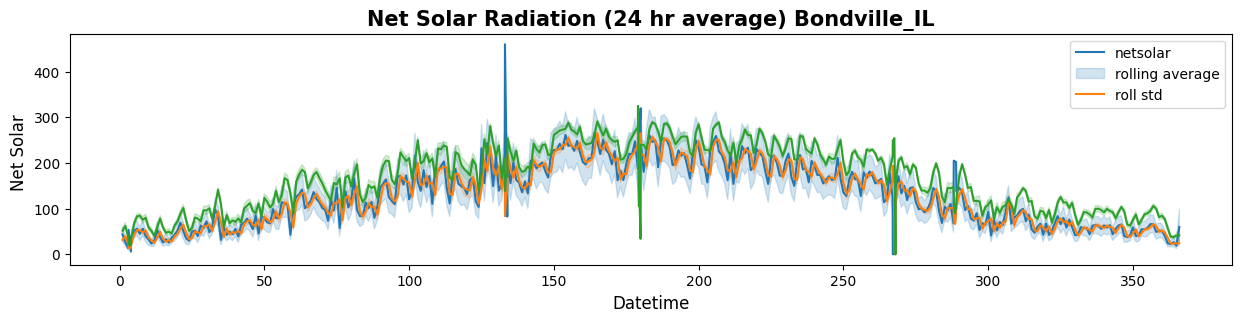

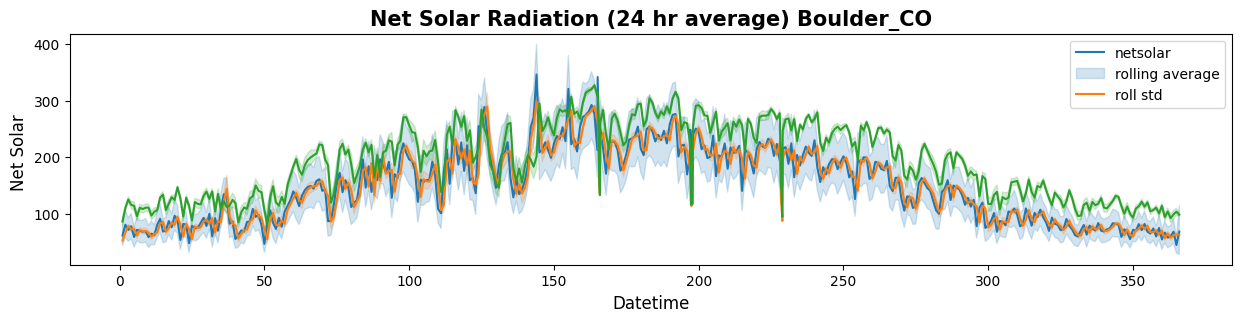

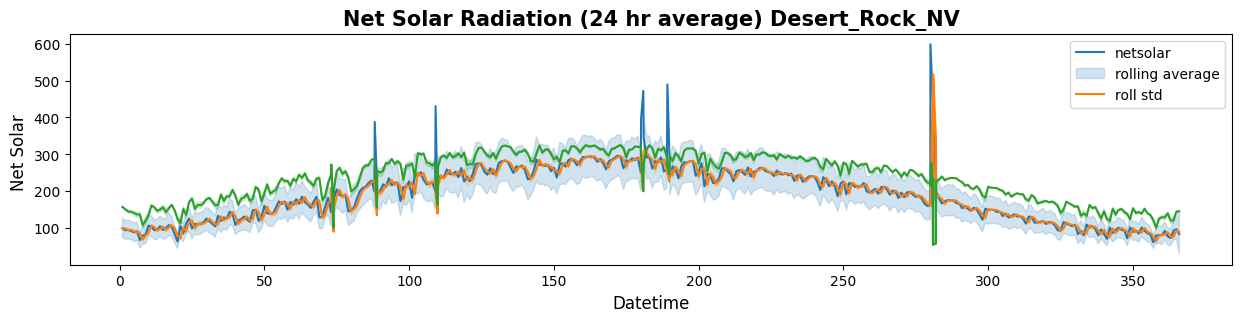

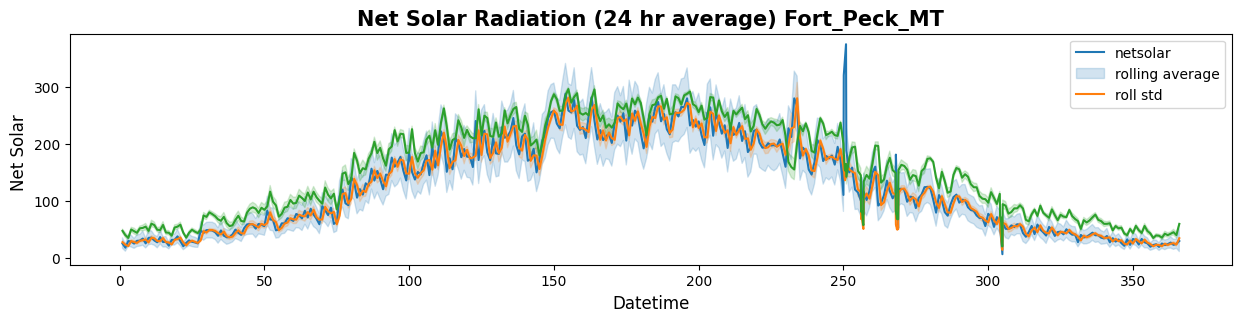

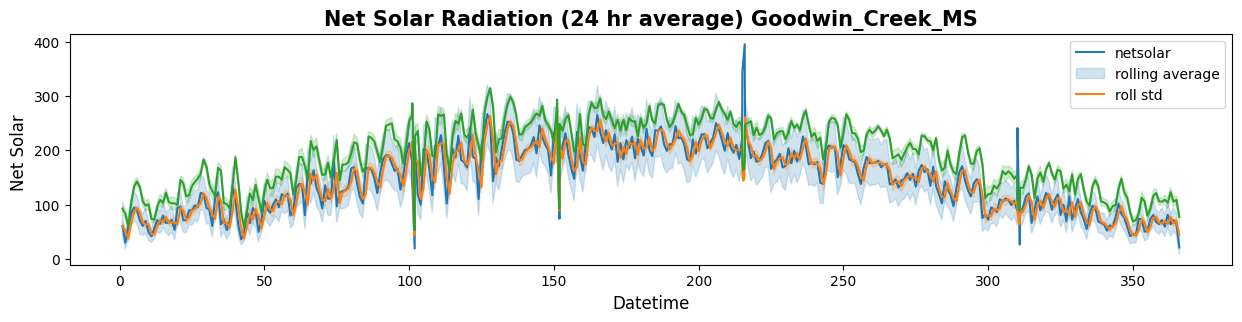

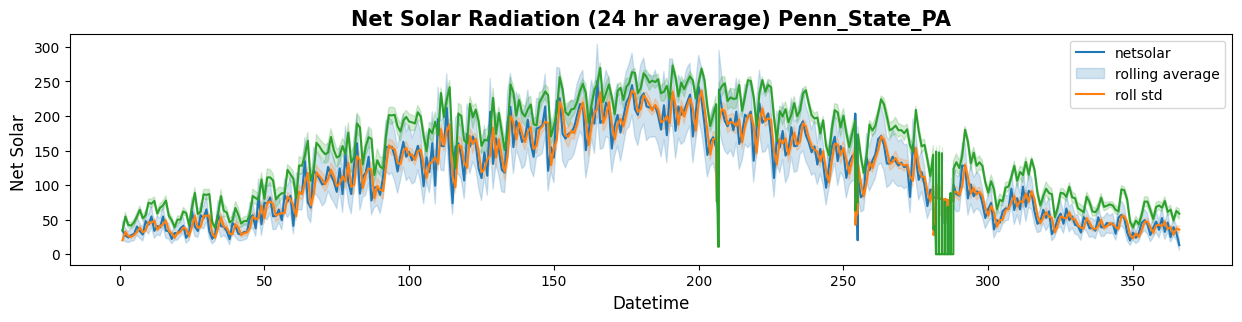

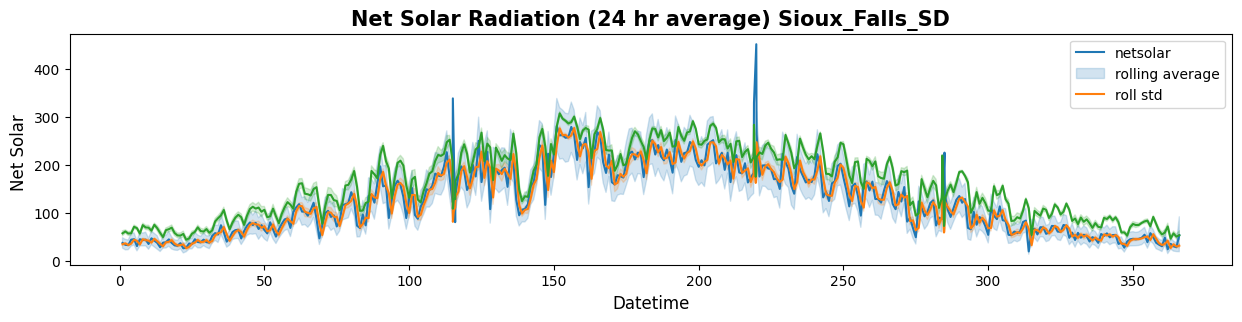

In [ ]:
column = "netsolar"

for location in self.merge_train_d["city"].unique():    
    plt.figure(figsize=(15,3))
    sns.lineplot(data=self.merge_train_h[self.merge_train_h["city"]==location], x="jday", y=column)
    sns.lineplot(data=self.roll_mean_h[location], x="jday", y=column)
    sns.lineplot(data=self.roll_std_h[location], x="jday", y=column)

    plt.xlabel("Datetime", fontsize=12)
    plt.ylabel("Net Solar ", fontsize=12)
    plt.legend([column, "rolling average", "roll std"], fontsize=10)
    plt.title(f"Net Solar Radiation (24 hr average) {location}", fontsize=15, fontweight="bold")
    plt.show()

In [ ]:
for city in self.merge_train_d["city"].unique():
    self.logger.info('\n'+location)
    self.adf_test(self.merge_train_d[self.merge_train_d["city"]==city]["netsolar"])


Sioux_Falls_SD
Test Statistic             -3.057153
p-value                     0.029891
#Lags Used                 14.000000
# Observations           1811.000000
Critical Value (1%)        -3.433966
Critical Value (5%)        -2.863137
Critical Value (10%)       -2.567620
dtype: float64
Series is Stationary

Sioux_Falls_SD
Test Statistic             -2.742394
p-value                     0.066985
#Lags Used                 25.000000
# Observations           1800.000000
Critical Value (1%)        -3.433988
Critical Value (5%)        -2.863147
Critical Value (10%)       -2.567626
dtype: float64
Series is Non-Stationary

Sioux_Falls_SD
Test Statistic             -2.295186
p-value                     0.173525
#Lags Used                 11.000000
# Observations           1814.000000
Critical Value (1%)        -3.433960
Critical Value (5%)        -2.863135
Critical Value (10%)       -2.567619
dtype: float64
Series is Non-Stationary

Sioux_Falls_SD
Test Statistic             -2.635180
p-valu

for city in self.merge_train_d["city"].unique():
    ts_components_plot(daily_comp=self.sd_24[city], 
                       weekly_comp=self.sd_168[city], 
                       yearly_comp=self.sd_8766[city],
                       city=city)

## Statistical Modelling

In [ ]:
self.merge_train_d = self.merge_train_d.fillna(0)

In [ ]:
for city in self.merge_train_d["city"].unique():
    self.logger.info("\n" + city)
    self.logger.info("Observed:")
    self.adf_test(self.merge_train_d[self.merge_train_d["city"]==city]["netsolar"])
    
    self.logger.info("Differenced:")
    self.adf_test(self.merge_train_d[self.merge_train_d["city"]==city]["netsolar_diff"])


Bondville_IL
Observed:
Test Statistic             -3.057153
p-value                     0.029891
#Lags Used                 14.000000
# Observations           1811.000000
Critical Value (1%)        -3.433966
Critical Value (5%)        -2.863137
Critical Value (10%)       -2.567620
dtype: float64
Series is Stationary
Differenced:
Test Statistic          -1.331563e+01
p-value                  6.612079e-25
#Lags Used               2.200000e+01
# Observations           1.803000e+03
Critical Value (1%)     -3.433982e+00
Critical Value (5%)     -2.863144e+00
Critical Value (10%)    -2.567624e+00
dtype: float64
Series is Stationary

Boulder_CO
Observed:
Test Statistic             -2.742394
p-value                     0.066985
#Lags Used                 25.000000
# Observations           1800.000000
Critical Value (1%)        -3.433988
Critical Value (5%)        -2.863147
Critical Value (10%)       -2.567626
dtype: float64
Series is Non-Stationary
Differenced:
Test Statistic          -1.39593

<Axes: xlabel='datetime'>

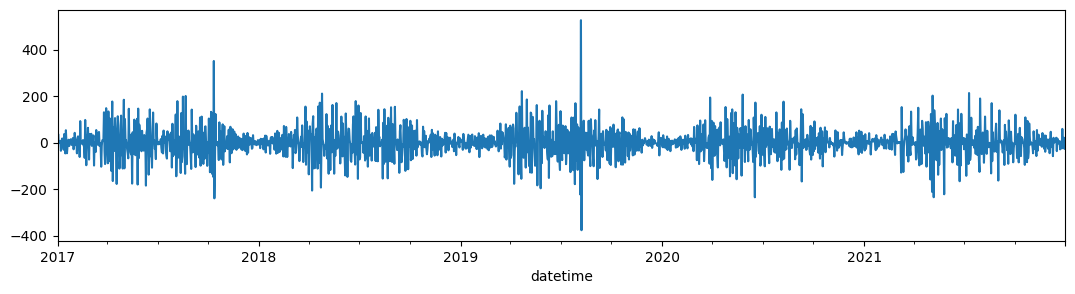

In [ ]:
self.merge_train_d[self.merge_train_d["city"]=="Sioux_Falls_SD"]["netsolar_diff"].plot(figsize=(13,3), fontsize=10)

In [ ]:
pacf_plot(x_var=self.merge_train_d[self.merge_train_d["city"]=="Sioux_Falls_SD"]["netsolar_diff"], lags=100)

NameError: name 'pacf_plot' is not defined

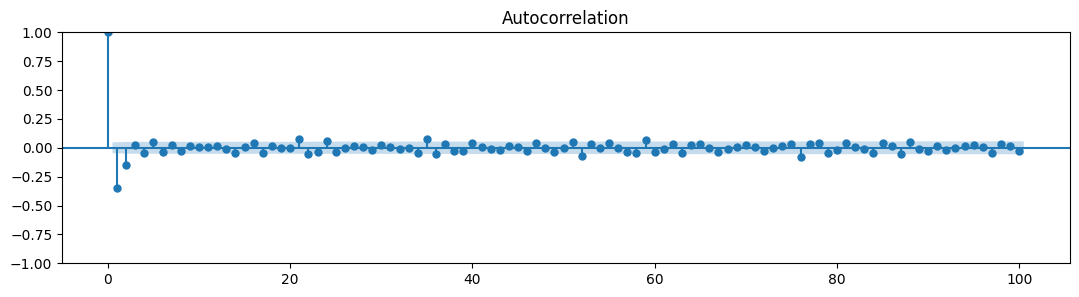

In [ ]:
acf_plot(x_var=self.merge_train_d[self.merge_train_d["city"]=="Sioux_Falls_SD"]["netsolar_diff"], lags=100)

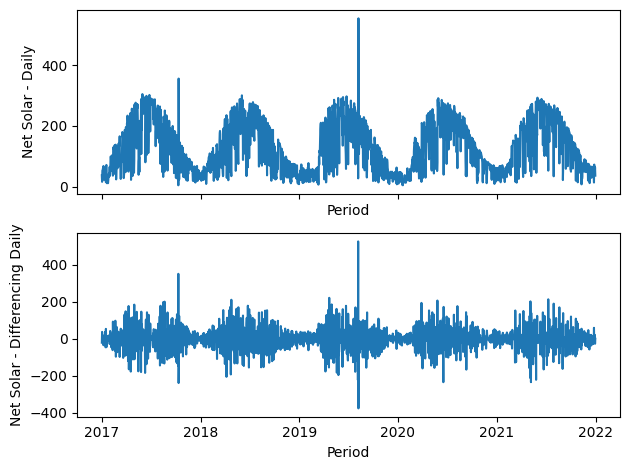

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)
ax1.plot(self.merge_train_d[self.merge_train_d["city"]=="Sioux_Falls_SD"]["netsolar"])
ax1.set_xlabel("Period")
ax1.set_ylabel('Net Solar - Daily')
# ax1.axvspan(450, 500, color="#808080", alpha=0.2)

ax2.plot(self.merge_train_d[self.merge_train_d["city"]=="Sioux_Falls_SD"]["netsolar_diff"])
ax2.set_xlabel("Period")
ax2.set_ylabel("Net Solar - Differencing Daily")
# ax2.axvspan(449, 498, color="#808080", alpha=0.2)

# fig.autofmt_xdate()
plt.tight_layout()